# Modeling dynamical systems on networks in Julia

This notebook showcases how to define dynamical systems supported on networks using three different methods.

In [2]:
using LinearAlgebra
using Graphs
using DifferentialEquations
using ModelingToolkit
using NetworkDynamics
using Random
using Symbolics: scalarize
using BenchmarkTools
using Plots
using StatsPlots

In [3]:
# Set the seed for reproducibility
Random.seed!(2023)

TaskLocalRNG()

In [4]:
N = 5
g = watts_strogatz(N, 4, 0.4)
u0 = rand(N,2)
a_ = 1.0
b_ = 3.0
L_ = float.(laplacian_matrix(g))
D_u_ = 0.5
D_v_ = 0.1
tspan = (0.0, 20.0)

(0.0, 20.0)

In [5]:
brusselator_x(x,y,a,b) = a + x^2 * y - b*x -x
brusselator_y(x,y,a,b) = b*x - x^2 * y

brusselator_y (generic function with 1 method)

In [6]:
function brusselator!(dx, x, p, t)
    a, b = p
    dx[1] = brusselator_x(x[1], x[2], a, b)
    dx[2] = brusselator_y(x[1], x[2], a, b)
end

brusselator! (generic function with 1 method)

In [7]:
function brusselator_rd!(du, u, p, t)
    p_b, L, D = p
    @views for i in axes(du, 1)
        brusselator!(du[i,:], u[i,:], p_b, t)
    end
    @views begin
        mul!(du[:,1], L, u[:,1], -D[1], 1.0) # du[:,1] .-= D[1]*L*u[:,1]
        mul!(du[:,2], L, u[:,2], -D[2], 1.0)
    end
end

brusselator_rd! (generic function with 1 method)

In [9]:
p = [[a_, b_], L_, [D_u_, D_v_]]
prob = ODEProblem(brusselator_rd!, u0, tspan, p)
sol = solve(prob, Rodas5())

retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 65-element Vector{Float64}:
  0.0
  0.03460094242359962
  0.07938345763847535
  0.13888757784264028
  0.21311034058692271
  0.30532119370043465
  0.41754422713823924
  0.553828279124587
  0.7193645629542668
  0.9226982062838679
  ⋮
 16.30684070889914
 16.60056084328424
 16.918478760598745
 17.295323916528215
 17.780604893994894
 18.265885871461574
 18.88377596108157
 19.55903402392607
 20.0
u: 65-element Vector{Matrix{Float64}}:
 [0.05798523166511249 0.1383929610938679; 0.5655548397194458 0.3330637780328449; … ; 0.7471957611034997 0.20156081508437584; 0.8245816388488778 0.7819248287604422]
 [0.1108606172310568 0.1512472074497721; 0.51943357493187 0.38593424631375706; … ; 0.6648730591413505 0.27302105146315403; 0.7382649033270772 0.83832309652095]
 [0.16174953125685393 0.17539484929373944; 0.4709641080262513 0.4478568395521454; … ; 0.580405278536153 0.35341695535704215; 0.646650705467598 0.9024

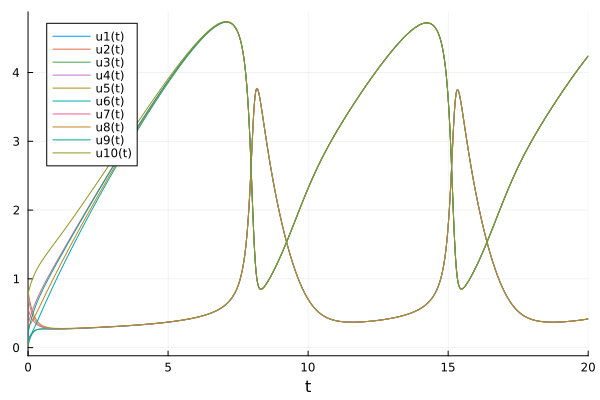

In [10]:
plot(sol)

In [11]:
@parameters t a b
@variables x(t) y(t)
D = Differential(t)

eqs_base = [
    D(x) ~ brusselator_x(x,y,a,b),
    D(y) ~ brusselator_y(x,y,a,b)
]

@named sys_base = ODESystem(eqs_base)


Model sys_base with 2 equations
States (2):
  x(t)
  y(t)
Parameters (2):
  a
  b

In [12]:
@parameters t a b L[1:N,1:N] D_u D_v
@variables u(t)[1:N] v(t)[1:N]
D = Differential(t)

dudt = brusselator_x.(u,v,a,b) - D_u * (L * u)
dvdt = brusselator_y.(u,v,a,b) - D_v * (L * v)

eqs = [
    D.(u) ~ dudt;
    D.(v) ~ dvdt
]

@named sys_rd = ODESystem(eqs)

Model sys_rd with 10 equations
States (10):
  (u(t))[1]
  (u(t))[2]
  (u(t))[3]
  (u(t))[4]
⋮
Parameters (29):
  L[1, 2]
  L[1, 5]
  L[1, 1]
  b
⋮

In [13]:
eqs

10-element Vector{Any}:
 (broadcast(~, broadcast(Differential(t), u(t)), broadcast(-, broadcast(brusselator_x, u(t), v(t), Ref(a), Ref(b)), broadcast(*, Ref(D_u), L*u(t)))))[1]
 (broadcast(~, broadcast(Differential(t), u(t)), broadcast(-, broadcast(brusselator_x, u(t), v(t), Ref(a), Ref(b)), broadcast(*, Ref(D_u), L*u(t)))))[2]
 (broadcast(~, broadcast(Differential(t), u(t)), broadcast(-, broadcast(brusselator_x, u(t), v(t), Ref(a), Ref(b)), broadcast(*, Ref(D_u), L*u(t)))))[3]
 (broadcast(~, broadcast(Differential(t), u(t)), broadcast(-, broadcast(brusselator_x, u(t), v(t), Ref(a), Ref(b)), broadcast(*, Ref(D_u), L*u(t)))))[4]
 (broadcast(~, broadcast(Differential(t), u(t)), broadcast(-, broadcast(brusselator_x, u(t), v(t), Ref(a), Ref(b)), broadcast(*, Ref(D_u), L*u(t)))))[5]
 (broadcast(~, broadcast(Differential(t), v(t)), broadcast(-, broadcast(brusselator_y, u(t), v(t), Ref(a), Ref(b)), broadcast(*, Ref(D_v), L*v(t)))))[1]
 (broadcast(~, broadcast(Differential(t), v(t)), broadcast

In [14]:
scalarize.(eqs)

10-element Vector{Equation}:
 Differential(t)((u(t))[1]) ~ a + ((u(t))[1]^2)*(v(t))[1] - (u(t))[1] - D_u*((u(t))[1]*L[1, 1] + (u(t))[2]*L[1, 2] + (u(t))[3]*L[1, 3] + (u(t))[4]*L[1, 4] + (u(t))[5]*L[1, 5]) - b*(u(t))[1]
 Differential(t)((u(t))[2]) ~ a + ((u(t))[2]^2)*(v(t))[2] - (u(t))[2] - D_u*((u(t))[1]*L[2, 1] + (u(t))[2]*L[2, 2] + (u(t))[3]*L[2, 3] + (u(t))[4]*L[2, 4] + (u(t))[5]*L[2, 5]) - b*(u(t))[2]
 Differential(t)((u(t))[3]) ~ a + ((u(t))[3]^2)*(v(t))[3] - (u(t))[3] - D_u*((u(t))[1]*L[3, 1] + (u(t))[2]*L[3, 2] + (u(t))[3]*L[3, 3] + (u(t))[4]*L[3, 4] + (u(t))[5]*L[3, 5]) - b*(u(t))[3]
 Differential(t)((u(t))[4]) ~ a + ((u(t))[4]^2)*(v(t))[4] - (u(t))[4] - D_u*((u(t))[1]*L[4, 1] + (u(t))[2]*L[4, 2] + (u(t))[3]*L[4, 3] + (u(t))[4]*L[4, 4] + (u(t))[5]*L[4, 5]) - b*(u(t))[4]
 Differential(t)((u(t))[5]) ~ a + ((u(t))[5]^2)*(v(t))[5] - (u(t))[5] - D_u*((u(t))[1]*L[5, 1] + (u(t))[2]*L[5, 2] + (u(t))[3]*L[5, 3] + (u(t))[4]*L[5, 4] + (u(t))[5]*L[5, 5]) - b*(u(t))[5]
 Differential(t)((v(t

In [15]:
p_mt = [
    a => a_,
    b => b_,
    collect(L .=> L_)...,
    D_u => D_u_,
    D_v => D_v_
]
u0_mt = [
    collect(u .=> u0[:,1]);
    collect(v .=> u0[:,2])
]
prob_mt = ODEProblem(sys_rd, u0_mt, tspan, p_mt)
sol_mt = solve(prob_mt, Rodas5())

retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 65-element Vector{Float64}:
  0.0
  0.03460094242359968
  0.07938345763847547
  0.1388875778426405
  0.21311034058692305
  0.3053211937004351
  0.4175442271382399
  0.5538282791245878
  0.7193645629542678
  0.9226982062838691
  ⋮
 16.306840708899156
 16.600560843284253
 16.91847876059876
 17.29532391652823
 17.78060489399491
 18.265885871461588
 18.883775961081586
 19.559034023926085
 20.0
u: 65-element Vector{Vector{Float64}}:
 [0.05798523166511249, 0.5655548397194458, 0.02297202215918681, 0.7471957611034997, 0.8245816388488778, 0.1383929610938679, 0.3330637780328449, 0.32532350864173976, 0.20156081508437584, 0.7819248287604422]
 [0.11086061723105697, 0.5194335749318703, 0.08289872711051241, 0.6648730591413501, 0.7382649033270771, 0.1512472074497721, 0.38593424631375695, 0.3317467689139132, 0.2730210514631543, 0.8383230965209498]
 [0.16174953125685432, 0.4709641080262515, 0.1409031405121173, 

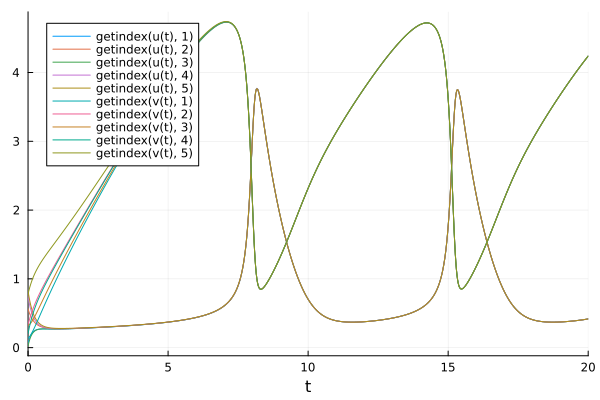

In [16]:
plot(sol_mt)

In [17]:
function rd_edge!(e, v_s, v_d, p, t)
    e .= v_s - v_d
    nothing
end

rd_edge! (generic function with 1 method)

In [18]:
function rd_vertex!(dv, v, edges, p, t)
    p_b, _, D = p
    brusselator!(dv, v, p_b, t)
    for e in edges
        dv .+= D .* e
    end
    nothing
end

rd_vertex! (generic function with 1 method)

In [19]:
nd_rd_vertex = ODEVertex(; f=rd_vertex!, dim=2)
nd_rd_edge = StaticEdge(; f=rd_edge!, dim=2, coupling=:antisymmetric)

nd_rd! = network_dynamics(nd_rd_vertex, nd_rd_edge, g)

(::ODEFunction{true, SciMLBase.FullSpecialize, NetworkDynamics.NetworkDE{SimpleGraph{Int64}, NetworkDynamics.GraphDataBuffer{Vector{Float64}, Vector{Float64}}, Float64, Float64, Vector{ODEVertex{typeof(rd_vertex!)}}, Vector{StaticEdge{NetworkDynamics.var"#16#25"{typeof(rd_edge!), Int64}}}}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Vector{Symbol}, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}) (generic function with 1 method)

In [20]:
prob_nd = ODEProblem(nd_rd!, vec(u0), tspan, p)
sol_nd = solve(prob_nd, Rodas5())

retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 64-element Vector{Float64}:
  0.0
  0.036751493673528535
  0.08523137390635256
  0.14949385343652322
  0.22970917960528983
  0.3289552918818111
  0.4493744136220686
  0.5953524406921011
  0.7732945539192597
  0.9941663778151905
  ⋮
 16.16010691817525
 16.41250689541876
 16.762331083682387
 17.112155271946015
 17.736779113826763
 18.118775796315138
 18.75601825342599
 19.39326071053684
 20.0
u: 64-element Vector{Vector{Float64}}:
 [0.05798523166511249, 0.5655548397194458, 0.02297202215918681, 0.7471957611034997, 0.8245816388488778, 0.1383929610938679, 0.3330637780328449, 0.32532350864173976, 0.20156081508437584, 0.7819248287604422]
 [0.10184961119034726, 0.5735468684451045, 0.07421724080304785, 0.7485417357664825, 0.7088931376950353, 0.2251021651032851, 0.31954532383215456, 0.3632799016019297, 0.2159221260847965, 0.7988618346362272]
 [0.14559061149265598, 0.5907751551807537, 0.12537429207748887

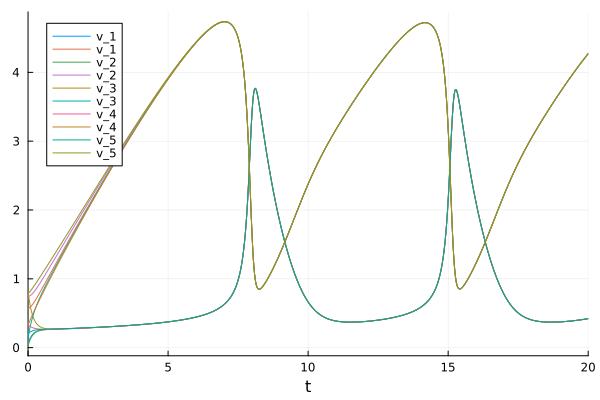

In [21]:
plot(sol_nd)

## Benchmarks

In [22]:
@benchmark brusselator_x(0.5,0.5,1.0,3.0)
@benchmark brusselator_y(0.5,0.5,1.0,3.0)


BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  0.861 ns … 10.790 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     0.870 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   0.935 ns ±  0.199 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▅▄        ▆▃    ▁▄                                        ▁
  ███▃▁▁▁▁▁▁▆██▃▁▃▁██▃▃▁▄▁▃▁▃▁▄▁▃▁▁▄▃▃▁▃▆▇▇▇▆█▅▅▅▅▅▅▄▄▃▃▃▇██ █
  0.861 ns     Histogram: log(frequency) by time     1.53 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [23]:
dx = zeros(2)
x = zeros(2)
p_b = [a_, b_]
@benchmark brusselator!(dx, x, p_b, 0.0)

BenchmarkTools.Trial: 10000 samples with 998 evaluations.
 Range (min … max):  14.387 ns …  5.723 μs  ┊ GC (min … max): 0.00% … 98.83%
 Time  (median):     16.838 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   19.289 ns ± 86.059 ns  ┊ GC (mean ± σ):  7.61% ±  1.71%

         █▄                                                    
  ▇█▄▆▅▅▃██▆▆▄▄▃▂▂▂▃▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  14.4 ns         Histogram: frequency by time        32.4 ns <

 Memory estimate: 16 bytes, allocs estimate: 1.

In [24]:
du = similar(u0)
b_sparse = @benchmark brusselator_rd!(du, u0, p, 0.0)

BenchmarkTools.Trial: 10000 samples with 310 evaluations.
 Range (min … max):  268.581 ns … 52.546 μs  ┊ GC (min … max):  0.00% … 98.84%
 Time  (median):     315.487 ns              ┊ GC (median):     0.00%
 Time  (mean ± σ):   571.724 ns ±  2.696 μs  ┊ GC (mean ± σ):  35.74% ±  7.59%

  ██▅▇▇▅▄▄▄▃▃▃▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁ ▁         ▁                     ▂
  █████████████████████████████████▇██████████▇▇▇▆▇▆▆▅▅▅▅▄▂▅▅▃ █
  269 ns        Histogram: log(frequency) by time       998 ns <

 Memory estimate: 896 bytes, allocs estimate: 28.

In [25]:
p_dense = [[a_,b_], Array(L_), [D_u_,D_v_]]
b_dense = @benchmark brusselator_rd!(du, u0, p_dense, 0.0)

BenchmarkTools.Trial: 10000 samples with 241 evaluations.
 Range (min … max):  301.133 ns … 50.872 μs  ┊ GC (min … max):  0.00% … 98.67%
 Time  (median):     352.809 ns              ┊ GC (median):     0.00%
 Time  (mean ± σ):   596.875 ns ±  3.152 μs  ┊ GC (mean ± σ):  38.57% ±  7.23%

     ▁ ▁▁▁▅█▅▁                                                  
  ▁▃▇█████████▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  301 ns          Histogram: frequency by time          628 ns <

 Memory estimate: 1.02 KiB, allocs estimate: 31.

In [26]:
f! = ODEFunction{true}(sys_rd)
u_vec = vec(u0)
du_vec = similar(u_vec)
p_ = [p.second for p in p_mt];

In [27]:
b_mt = @benchmark f!(du_vec, u_vec, p_, 0.0)

BenchmarkTools.Trial: 10000 samples with 815 evaluations.
 Range (min … max):  152.702 ns …  13.980 μs  ┊ GC (min … max): 0.00% … 98.57%
 Time  (median):     167.104 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   180.954 ns ± 235.266 ns  ┊ GC (mean ± σ):  2.80% ±  2.19%

  ▂██▆▆▄▃▃▃█▆▅▄▃▃▂▂▂▂▁                                          ▂
  ███████████████████████▇▇▇▆▇▆▆▇▇▇▇▇▇▇▇▆▇▇▆▇▇▇▇▇▇▅▆▆▅▇▆▆▅▆▆▆▆▅ █
  153 ns        Histogram: log(frequency) by time        308 ns <

 Memory estimate: 32 bytes, allocs estimate: 1.

In [28]:
b_nd = @benchmark nd_rd!(du_vec, u_vec, p, 0.0)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  12.893 μs …   8.250 ms  ┊ GC (min … max): 0.00% … 99.34%
 Time  (median):     14.813 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.708 μs ± 115.442 μs  ┊ GC (mean ± σ):  9.72% ±  1.40%

   ▆▄▁▂▁   ▆█                                                   
  ▄█████▅▂▄██▇▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  12.9 μs         Histogram: frequency by time         26.8 μs <

 Memory estimate: 9.09 KiB, allocs estimate: 171.

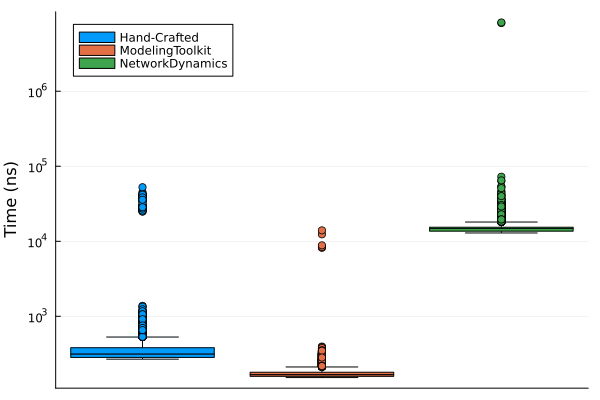

In [35]:
boxplot(b_sparse.times, 
    label="Hand-Crafted",
    ylabel="Time (ns)",
    yticks=10 .^(3:6),
    xticks = [],
    yscale=:log10, 
    legend=:topleft)
#boxplot!(b_dense.times, label="Hand-Crafted (Dense Matrix)")
boxplot!(b_mt.times, label="ModelingToolkit")
boxplot!(b_nd.times, label="NetworkDynamics")